# Stress Classifier
## Overview
* Data Extraction: Downloads and sorts through database
* Signal processing: 
    + Pre-processing - filtering and signal cleaning
    + Feature Extraction - R-R peaks, PQRST peaks, EDR, in addition to mean, kurtosis etc.

## Settings and Globals
Modify settings to select database, model etc. and tune model

In [3]:

# SETTINGS

# Database:
database = "Spider" # database = "BrainPatch"

# Preprocessing / Feature Extraction:
window_length = 40 # window length in seconds
overlap = 0.1 # overlap percentage for rolling window (increasing will result in more overlapped samples)

if database == 'Spider':
    sampling_rate = 100
    number_of_participants = 56

directory = f'Data/{database}/StoredDataFrames'

In [4]:
# Import necessary modules
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import os
import subprocess
import warnings
import seaborn as sns
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product

In [5]:
# Useful Utilities
class Utilities():
    def __init__(self) -> None:
        pass
    

    def progress_bar(current, total, bar_length=20):
        fraction = current / total

        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '

        ending = '\n' if current == total else '\r'

        print(f'Progress: [{arrow}{padding}] {int(fraction*100)}%', end=ending)


    def print_overwrite(msg):
        # add padding to line 
        padding = ' ' * 20
        # Print the padded message and remember it as the previous message
        print(msg+padding, end="\r")


    def check_csv_exists(folder_path, index):
        # read the CSV file into a dataframe and append to the list
        filename = os.path.join(folder_path, f'df_{index}.csv')
        try:
            df = pd.read_csv(filename)
        except FileNotFoundError:
            return False
        return filename


    def load_dataframe(filename):
        # read the CSV file into a dataframe and append to the list
        df = pd.read_csv(filename)
        return df


    def save_dataframe(df, folder_path, index=-1, name=''):
        # create directoy if necessary
        os.makedirs(folder_path, exist_ok=True) 
        # either store as an index or store as name
        if index!=-1:
            filename = os.path.join(folder_path, f'df_{index}.csv')
        else:
            filename = os.path.join(folder_path, f'{name}.csv')
        # if filename already exists, concatenate vertically with it.
        if os.path.exists(filename):
            df_new = pd.concat([Utilities.load_dataframe(filename), df], axis=0, ignore_index=True)
            df_new.to_csv(filename, index=False)
        # otherwise, save as new file
        else:
            df.to_csv(filename, index=False)

    
    def save_list_of_dataframes(df_list, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        # save each dataframe as a CSV file in the folder
        for i, df in enumerate(df_list):
            filename = os.path.join(folder_path, f'df_{i}.csv')
            df.to_csv(filename, index=False)
            Utilities.progress_bar(i+1, len(df_list))

    
# for interactive matplotlib:
# %matplotlib widget 
# Bigger plots
plt.rcParams['figure.figsize'] = [10, 6]  
plt.rcParams['font.size']= 14

In [6]:
# Define DataExtraction class
class DataExtraction():
    def __init__(self, save_to_path):
        self.save_to_path = save_to_path


    # Extract data and store to file named Data
    def download_data(self):
        if database == 'Spider':
            directory = 'Data/Spider'
            url = 'https://physionet.org/files/ecg-spider-clip/1.0.0/'
            if not os.path.isdir(directory):
                print("Downloading database...this may take a while")
                os.makedirs(directory)
                cmd = f"wget -r -N -c -np -P {directory} {url}"
                print(cmd)
                try:
                    subprocess.run(cmd)
                except:
                    print("Error: Unable to download database")
                    os.rmdir(directory)
            else:
                print("Using pre-downloaded database")
    

    # sorts data into a single dataframe for each participant into a collective dataframe list
    def sort_data(self):
        print("Sorting data...")

        # try loading existing df if available
        if os.path.isdir(self.save_to_path):
            return
        
        # otherwise create dataframe from scratch
        ECG_df = []

        if database == 'Spider':
            database_directory = 'Data/Spider/physionet.org/files/ecg-spider-clip/1.0.0/'
            # Exclude VP70 because of noise
            sub_directories = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
                    'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
                    'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP71','VP72','VP73','VP74',
                    'VP75','VP76','VP77','VP78','VP79','VP80']
            for index, sub in enumerate(sub_directories):
                # set path
                ECG_file = f'{database_directory}{sub}/BitalinoECG.txt'
                triggers_file = f'{database_directory}{sub}/Triggers.txt'

                # append data to dataframe
                ECG_participant_df = pd.read_csv(ECG_file, sep='\t', names = ['ECG','Timestamp','NA'])
                ECG_participant_df = ECG_participant_df.drop(columns=['NA'])
                
                # set the start time to use to normalize the other times
                normalized_time = ECG_participant_df.iloc[0,1]
                ECG_participant_df.Timestamp = ECG_participant_df.Timestamp-normalized_time

                # read in trigger file
                triggers_df_temp = pd.read_csv(triggers_file, sep='\t', names = ['clip','on','off'])
                # normalize time series
                triggers_df_temp.on = triggers_df_temp.on-normalized_time
                triggers_df_temp.off = triggers_df_temp.off-normalized_time

                # Create the 'Stressed' (label) column with all zeros
                ECG_participant_df["Stressed"] = np.zeros(len(ECG_participant_df))
                # This checks which time stamps fall into the time ranges when the clips are delivered (ignoring demo clip), results in a column of "true" and "false"
                conditions = pd.concat([(ECG_participant_df['Timestamp'] >= triggers_df_temp.on[i]) & (ECG_participant_df['Timestamp'] <= triggers_df_temp.off[i]) for i in range(1,17)],axis=1).any(axis=1)
                ECG_participant_df["Stressed"] = conditions
                # move stressed label to first column
                ECG_participant_df.insert(0, "Stressed", ECG_participant_df.pop('Stressed'))

                # append data to complete df dictionary
                ECG_df.append(ECG_participant_df)

                Utilities.progress_bar(index, len(sub_directories)-1)

        # save dataframe for nextime
        print("Saving sorted data...")
        Utilities.save_list_of_dataframes(ECG_df, self.save_to_path)

## 1.0 Data Extraction and sorting
* Downloads data, normalizes timeframe, attaches labels, and saves sorted data to Sorted directory

In [7]:
de = DataExtraction(f'{directory}/Sorted')
de.download_data()
de.sort_data()

Using pre-downloaded database
Sorting data...


In [8]:
# Define PreProcessing Class:
# Segments data using rolling window 
# Cleans data using Neurokit2
# Documentation can be found here: https://neuropsychology.github.io/NeuroKit/functions/ecg.html       
class PreProcessing():
    def __init__(self, ECG_df:pd.DataFrame, sampling_rate:int):
        self.ECG_df = ECG_df
        self.sampling_rate = sampling_rate

    # interpolates data to achieve sampling rate
    def interpolate(self):
        if database == 'Spider':
            # print("Timestamps are not valid for Spider database. Not interpolating.")
            return

        # convert timestamp column to a NumPy array
        timestamps = self.ECG_df['Timestamp'].to_numpy()

        # calculate the time difference between each pair of adjacent timestamps
        time_diff = np.diff(timestamps)

        # calculate the average sampling rate of the data
        sampling_rate = 1 / np.mean(time_diff)

        print(f"Average sampling rate: {sampling_rate}")

        # interpolate the data to obtain 100Hz sampling rate
        self.ECG_df['Timestamp'] = np.arange(timestamps[0], timestamps[-1], 1 / self.sampling_rate)
        self.ECG_df['ECG'] = np.interp(self.ECG_df['Timestamp'], timestamps, self.ECG_df['ECG'])
        

    # segments data with overlap using rolling window
    def segment(self, window_length, overlap)->tuple:
        # convert window_length in seconds to samples
        window_samples = window_length * sampling_rate
        # Calculate the step_size as the fraction of the total window samples
        step_size = int(window_samples * (1-overlap)) 

        # Save windowed samples to dictionary containing a list of numpy arrays for each label type
        self.sampled_ECG = {"Stressed": [], "Not stressed": []}

        # Initialize starting variables
        current_index = 0
        current_stressed = self.ECG_df['Stressed'][current_index]
        
        # Loop through the entire dataframe
        while current_index < len(self.ECG_df['ECG']):  
            # calculate next index and exit if out of bounds          
            next_index = current_index + step_size
            if (next_index > len(self.ECG_df['ECG'])):
                return
            # Check if the window overlaps different label in next window
            next_stressed = self.ECG_df['Stressed'][next_index]

            # If the next window has a different label, update index to start of new label
            if next_stressed != current_stressed:
                current_index = next_index
                current_stressed = next_stressed
            else:
                # Extract the window into stressed or not stressed dataframes
                if current_stressed:
                    self.sampled_ECG["Stressed"].append(self.ECG_df['ECG'].iloc[current_index:current_index+window_samples].to_numpy())
                else:
                    self.sampled_ECG["Not stressed"].append(self.ECG_df['ECG'].iloc[current_index:current_index+window_samples].to_numpy())
                # If the next window has the same label, shift the window
                current_index += step_size


    def clean(self):
        # Clean each sample in the stressed and not stressed data (overwrites original data)
        # using method 'neurokit' (0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering) but can be changed to other cleaning methods
        for label in self.sampled_ECG.keys():
            for sample in self.sampled_ECG[label]:
                sample = nk.ecg_clean(sample, self.sampling_rate, method='neurokit')


    # returns dictionary with list of samples - stressed and not stressed
    def get_samples(self):
        return self.sampled_ECG

In [9]:
# Define parameters for feature extraction
class FE_Parameter:
    def __init__(self, name:str, min:float=0.0, max:float=9999):
        self.name = name
        self.min = min
        self.max = max

In [10]:
# Define FeatureExtraction Class
# Main class that extracts features from a dictionary of sorted dataframes and stores to csv
class FeatureExtraction():
    # takes in cleaned ECG data
    def __init__(self, sampled_ECG:dict=None, show_plot=False):
        self.show_plot = show_plot
        self.sampled_ECG = sampled_ECG
        # copy dictionary keys from sampled_ECG to all_features_ECG and selected_features_ECG
        self.all_features_ECG = {label: pd.DataFrame for label in sampled_ECG.keys()} 


    def add_to_featured_df(self, df, label):
        if self.all_features_ECG[label].empty:
            self.all_features_ECG[label] = df
        else:
            self.all_features_ECG[label] = pd.concat([self.all_features_ECG[label], df], axis=0, ignore_index=True)


    # Extracts features from ECG using neurokit.
    def get_neurokit_features(self, EDR=False):
        for label in self.sampled_ECG.keys():
            for index, sample in enumerate(self.sampled_ECG[label]):
                # only show plot once
                if index!=0:
                    self.show_plot = False 
                # extract R-R peaks
                np.seterr(divide="ignore", invalid="ignore")
                r_peaks_df = nk.ecg_peaks(sample, sampling_rate=sampling_rate, correct_artifacts=True)[0]

                # Extract HRV features from R-R peaks, see https://neuropsychology.github.io/NeuroKit/functions/hrv.html 
                # compute HRV - time, frequency and nonlinear indices.
                warnings.filterwarnings('ignore') # temporarily supress warnings
                features = nk.hrv(r_peaks_df, sampling_rate=sampling_rate, show=self.show_plot)
                warnings.filterwarnings('default')
                # compute Shannon Entropy (SE) using signal symbolization and discretization
                # see https://neuropsychology.github.io/NeuroKit/functions/complexity.html#entropy-shannon 
                SE = nk.entropy_shannon(sample, symbolize='A')[0]
                HRV_SE = pd.DataFrame([SE], columns=['HRV_SE'])
                # concat to dataframe
                features = pd.concat([features, HRV_SE], axis=1)
                
                if EDR:
                    # Get ECG Derived Respiration (EDR) and add to the data
                    warnings.filterwarnings('ignore') # temporarily supress warnings
                    ecg_rate = nk.signal_rate(r_peaks_df, sampling_rate=sampling_rate, desired_length=len(r_peaks_df))
                    warnings.filterwarnings('default')
                    EDR_sample = nk.ecg_rsp(ecg_rate, sampling_rate=sampling_rate)
                    info = nk.signal_findpeaks(EDR_sample)
                    # add feature to dataframe
                    # self.add_to_featured_df(pd.DataFrame(EDR, columns=['EDR']), label, index)
                    
                # concatenate to all_features_ECG dataframe
                self.add_to_featured_df(features, label)


    # saves selected or all features to concatenated csv
    def save_features(self, save_to_path):
        for label in self.all_features_ECG.keys():
            if database == 'Spider':
                self.all_features_ECG[label].loc[:, 'Stressed'] = 1 if label == 'Stressed' else 0
            Utilities.save_dataframe(self.all_features_ECG[label], f'{save_to_path}/All', name=f'Featured_ECG_with_{window_length}s_Window_Length')
                


## Pre-Processing and Feature Extraction
* Cleans data using Neurokit's 5th Order Butterworth filter.
* Extracts features such as HRV time, frequency and non-linear domain, EDR etc. and saves them to Feature directory

In [11]:
# For each participant, segment, clean and extract features from ECG recordings
# Skip if feature file exists
if os.path.exists(f'{directory}/Features/All/Featured_ECG_with_{window_length}s_Window_Length.csv'):
    print("Skipping Feature Extraction")
else:
    print("Feature Extraction...")
    for index in range(number_of_participants):
        # show plots for first participant only
        show_plot = True if index==0 else False

        # Extract features using sorted data:
        df = Utilities.load_dataframe(Utilities.check_csv_exists(f'{directory}/Sorted', index))
        # interpolate, segment using sliding window, and clean data
        pp = PreProcessing(df, sampling_rate)
        pp.interpolate()
        pp.segment(window_length, overlap)
        pp.clean()

        # extract feautres for each segment
        fe = FeatureExtraction(pp.get_samples(), show_plot)
        fe.get_neurokit_features(EDR=False)
        fe.save_features(f'{directory}/Features')
        Utilities.progress_bar(index+1, number_of_participants)

Skipping Feature Extraction


## 3. Feature Selection:
* Visualise most useful features
* Select desired features, sanity check the values, and save them to Features directory

In [12]:
# Define FeatureSelection class that is used to visualise and select data
class FeatureSelection():
    def __init__(self, path):
        self.save_to_path = path
        self.selected_features = Utilities.load_dataframe(f'{path}/All/Featured_ECG_with_{window_length}s_Window_Length.csv')

    
    def visualise(self, plot_type='pairplot'):
        print("Generating plot...")
        if plot_type == 'pairplot':         
            sns.pairplot(data = self.selected_features, hue = 'Stressed')
        elif plot_type == 'kdeplot':
            # Create a figure with subplots for each feature
            subplot_size = math.ceil(math.sqrt(len(self.selected_features.columns) - 1))
            fig = plt.figure(figsize=(20, 8*subplot_size))

            # Loop through each feature and add it to a subplot
            for i, feature in enumerate(self.selected_features.loc[:, self.selected_features.columns != 'Stressed']):
                fig.add_subplot(subplot_size, subplot_size, i+1)
                sns.kdeplot(x=feature, data=self.selected_features, hue='Stressed', common_norm=False, warn_singular=False)
            plt.show()
        else:
            print("Plot type not recognised. Please choose between pairplot, kdeplot")


    # Copies selected features from all feature csv file to selected feature csv 
    # desired_features is a list of FE_Parameter objects  
    def select(self, desired_features:list):
        new_selected_features = pd.DataFrame()
        for feature in desired_features:
            # Sanity check: check if feature exists
            if feature.name in self.selected_features.columns:
                # Set value to NaN if it falls outside min and max values.
                for i, value in enumerate(self.selected_features[feature.name]):
                    if (value < feature.min) or (value > feature.max):
                        self.selected_features.loc[i, feature.name] = np.nan
                # Add column to new selected features
                new_selected_features[feature.name] = self.selected_features[feature.name]
            else:
                print(f'Error: No such feature "{feature}" in extracted features')
        # add the label column as well
        new_selected_features['Stressed'] = self.selected_features['Stressed']
        # overwrite selected features with new ones selected
        self.selected_features = new_selected_features


    # impute missing values in dataset with mean values of column
    def impute(self):
        self.selected_features.replace([np.inf, -np.inf], np.nan, inplace=True)
        imp = SimpleImputer(strategy='mean')
        imp.fit(self.selected_features)
        self.dataset = pd.DataFrame(imp.transform(self.selected_features))


    def save_features(self):
        Utilities.save_dataframe(self.selected_features, f'{self.save_to_path}/Selected', name=f'Featured_ECG_with_{window_length}s_Window_Length')

### Select Desired Features and Visualise Cross Features

In [13]:
# See Neurokit2 HRV - https://neuropsychology.github.io/NeuroKit/functions/hrv.html

# Minimum and maximum expected HR (beats per min)
min_HR = 30
max_HR = 200

# MinNN: The minimum of the RR intervals (Parent, 2019; Subramaniam, 2022).
HRV_MinNN = FE_Parameter('HRV_MinNN', min=60000.0/max_HR, max=60000.0/min_HR)
# MaxNN: The maximum of the RR intervals (Parent, 2019; Subramaniam, 2022).
HRV_MaxNN = FE_Parameter('HRV_MaxNN', min=60000.0/max_HR, max=60000.0/min_HR)
# MeanNN: The mean of the RR intervals.
HRV_MeanNN = FE_Parameter('HRV_MeanNN', min=60000.0/max_HR, max=60000.0/min_HR)

# SDNN: The standard deviation of the RR intervals.
# See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/ for chosen min and max values.
HRV_SDNN = FE_Parameter('HRV_SDNN', min=30, max=150)
# RMSSD: The square root of the mean of the squared successive differences between adjacent RR intervals. 
# # It is equivalent (although on another scale) to SD1, and therefore it is redundant to report correlations with both (Ciccone, 2017).
# See https://help.welltory.com/en/articles/4413231-what-normal-ranges-and-measurement-standards-we-use-to-interpret-your-heart-rate-variability for chosen min and max values.
HRV_RMSSD = FE_Parameter('HRV_RMSSD', min=13, max=107)
# The root mean square of successive differences (RMSSD) divided by the mean of the RR intervals (MeanNN).
CVSD = FE_Parameter('HRV_CVSD')
# Shannon Entropy
HRV_SE = FE_Parameter('HRV_SE')

# pNN50: The proportion of RR intervals greater than 20ms, out of the total number of RR intervals.
HRV_pNN50 = FE_Parameter('HRV_pNN20')
# A geometrical parameter of the HRV, or more specifically, the baseline width of the RR intervals distribution 
# TINN: obtained by triangular interpolation, where the error of least squares determines the triangle. 
# It is an approximation of the RR interval distribution.
HRV_TINN = FE_Parameter('HRV_TINN')
# HTI: The HRV triangular index, measuring the total number of RR intervals divided by the height of the RR intervals histogram.
HRV_HTI = FE_Parameter('HRV_HTI')

# VLF: The spectral power (W/Hz) of very low frequencies (.0033 to .04 Hz).
# HRV_VLF = FE_Parameter('HRV_VLF', min=0.0, max=9) # hidden due to use of 0.5 Hz high-pass butterworth filter
# LF: The spectral power (W/Hz) of low frequencies (.04 to .15 Hz).
HRV_LF = FE_Parameter('HRV_LF', max=1.00)
# HF: The spectral power (W/Hz) of high frequencies (.15 to .4 Hz).
HRV_HF = FE_Parameter('HRV_HF', max=1.00)
# LFHF: The ratio obtained by dividing the low frequency power by the high frequency power.
HRV_LFHF = FE_Parameter('HRV_LFHF', max=1.00)


# Append all FE parameters to a list which will be passed to Feature_Extraction's Select method
selected_features = []
all_variables = dict(globals(), **locals())
for name, var in all_variables.items():
    if isinstance(var, FE_Parameter):
        selected_features.append(var)

Generating plot...


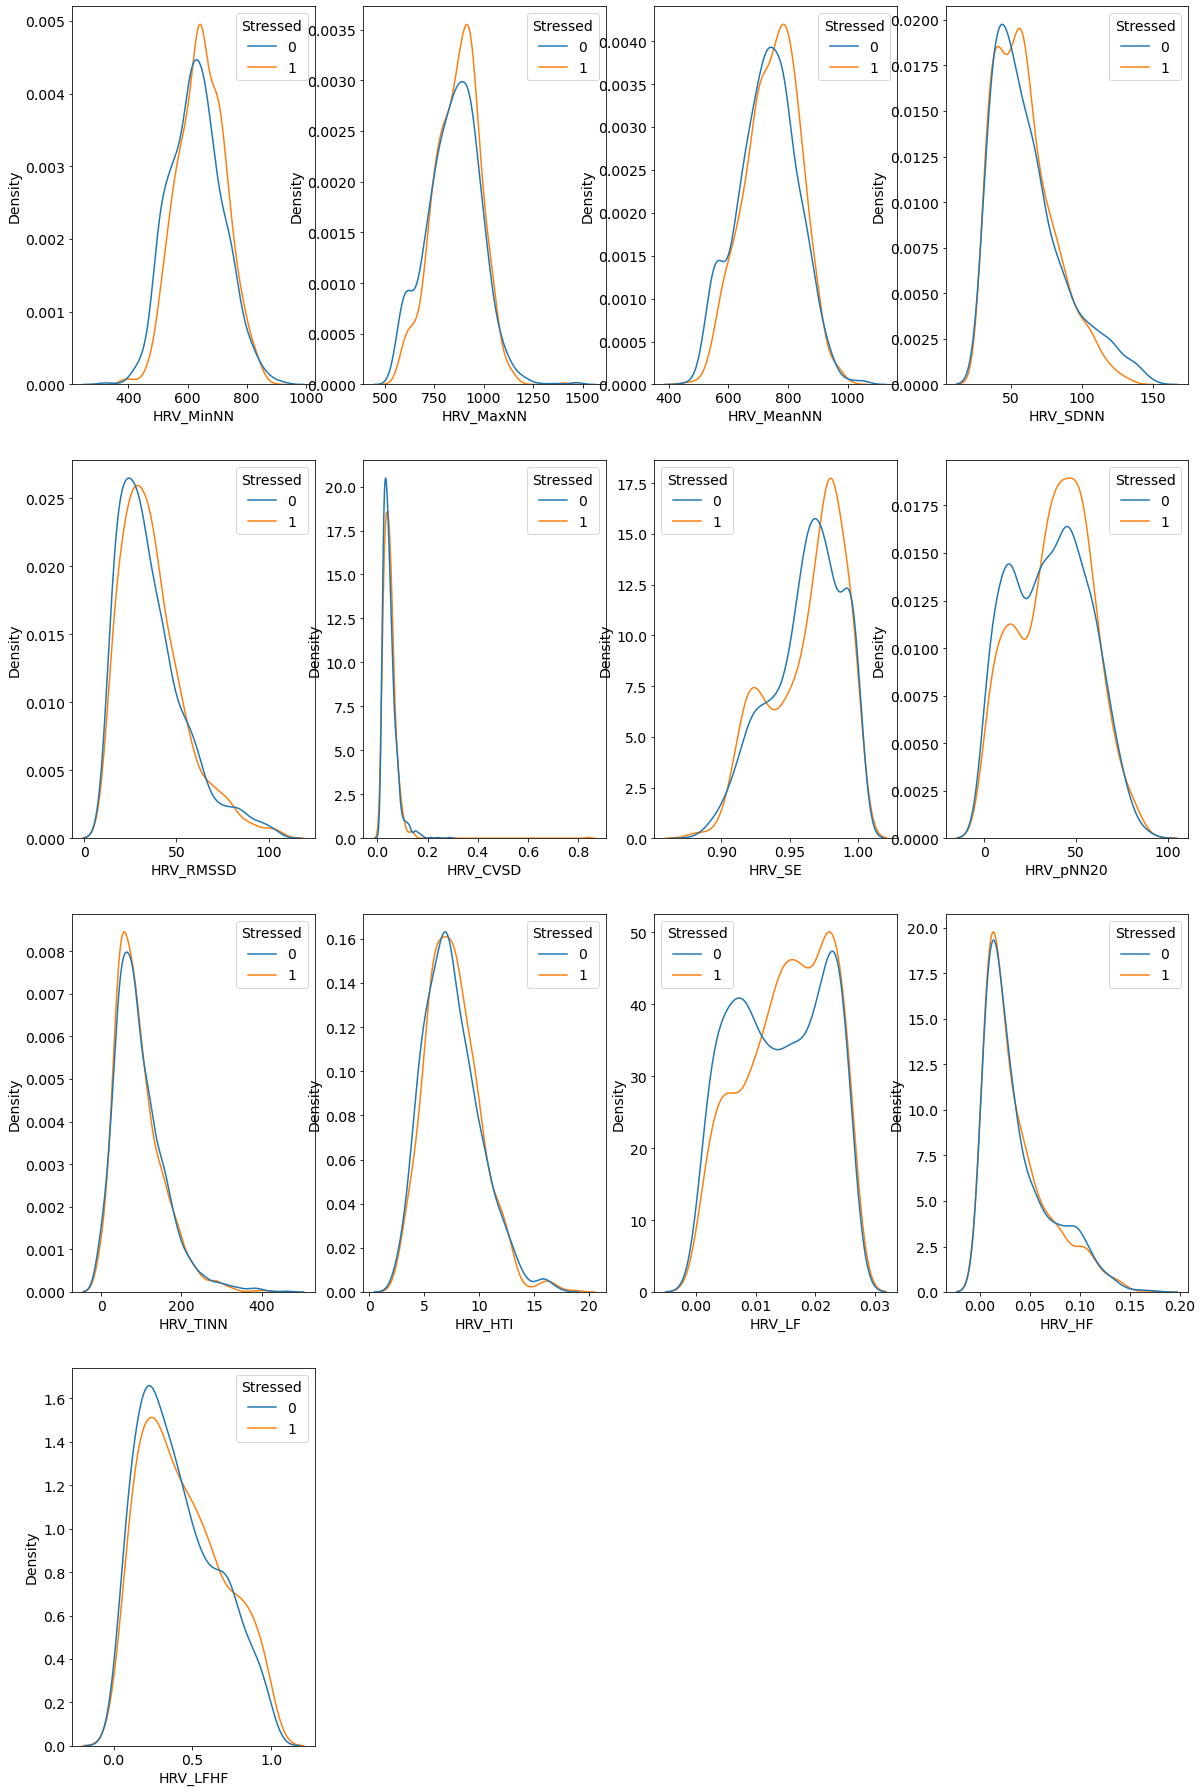

Generating plot...


In [15]:
# Skip if feature file exists
if os.path.exists(f'{directory}/Features/Selected/Featured_ECG_with_{window_length}s_Window_Length.csv'):
    print("Skipping Feature Selection")
else:
    fs = FeatureSelection(f'{directory}/Features')
    fs.select(selected_features)
    fs.impute()
    fs.visualise(plot_type='kdeplot')
    fs.visualise(plot_type='pairplot')
    fs.save_features()

## 4. Linear Classification
* Tunes
* Classifies using LDA, Random Forests

In [122]:
# Define LinearML method, which implements different linear classification methods
class Linear_ML():
    def __init__(self, dataset):
        self.dataset = dataset

    
    # randomizes, standardizes, and splits into test and training data.
    def prepare(self, test_split:float, dimension_reudction=False):       
        # split into test and training data
        dataset_size = len(self.dataset.columns)
        features = self.dataset.iloc[:, 0:dataset_size-1].values
        label = self.dataset.iloc[:,dataset_size-1].values
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(features, label, test_size=test_split, shuffle=True)

        # scale 
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)

        # LDA
        if dimension_reudction:
            lda = LinearDiscriminantAnalysis()
            self.X_train = lda.fit_transform(self.X_train, self.y_train)
            self.X_test = lda.transform(self.X_test)
            # Define model evaluation method (k-fold cross-validation)
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=None)

            #evaluate model
            scores = cross_val_score(lda, features, label, scoring='accuracy', cv=cv, n_jobs=-1)
            # summarize result
            print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


    # Tunning Random Forest
    def rf_tuner(self):
        n_estimators = 100
        max_features = [1, 'sqrt', 'log2']
        max_depths = [None, 2, 3, 4, 5]
        for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
            rf = RandomForestClassifier(n_estimators=n_estimators, 
                                        criterion='entropy', 
                                        max_features=f, 
                                        max_depth=d, 
                                        n_jobs=2,
                                        random_state=1337)
            rf.fit(self.X_train, self.y_train)
            self.y_pred = rf.predict(X=self.X_test)
            print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(self.y_test,self.y_pred)))
            self.plot_confustion_matrix()


    # Pre-tuned Random Forests Classifier
    def rf_classifier(self):
        # source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
        rf.fit(self.X_train, self.y_train)
        self.y_pred = rf.predict(X=self.X_test)

        # Accuracy on Test
        print("Training Accuracy is: ", rf.score(self.X_train, self.y_train))
        # Accuracy on Train
        print("Testing Accuracy is: ", rf.score(self.X_test, self.y_test))

        self.plot_confustion_matrix()

    
    def plot_confustion_matrix(self):
        # Confusion Matrix
        ConfusionMatrixDisplay.from_predictions(self.y_test, self.y_pred, display_labels=['Negative', 'Positive'])


    # main method to conduct LDA
    def model(self, classification_type):
        classification_types = {
            "RF": self.rf_classifier
        }
        classification_types.get(classification_type, lambda: print("Invalid input"))()        


In [123]:
# Retreive dataset of pre-processed and featured data from csv 
dataset_path = f'{directory}/Features/Selected/Featured_ECG_with_{window_length}s_Window_Length.csv'
dataset = Utilities.load_dataframe(dataset_path)

# pass to LinearML class
lml = Linear_ML(dataset)
# prepare dataset, split to a 33% test split and use LDA for dimension reduction
lml.prepare(0.33, dimension_reudction=False)
# run Random Forest Tuner
lml.rf_tuner()

#lml.model('RF')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Spider/StoredDataFrames/Features/Selected/Featured_ECG_with_40s_Window_Length.csv'